## **Extracción y Limpieza (Fase de Preprocesamiento de datos)**

Hemos decidido como grupo bajar información de la API del Banco Mundial, dado que los datos de esa fuente siempre se actualiza.
Nos hemos ayudado de ***requests*** para filtrar específicamente el **PBI** del Perú 

In [20]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 
import statsmodels.formula.api as smf 
import statsmodels.formula.api as qqplot
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
url = "https://data360api.worldbank.org/data360/data"
# indicador del PBI en el perú
parametros = {
            "DATABASE_ID": "WB_WDI",
            "REF_AREA": "PER",
            "INDICATOR": "WB_WDI_NY_GDP_MKTP_KD"
        }
response = requests.get(url, params=parametros)
json_data = response.json()
df = pd.DataFrame(json_data['value'])
cols = ['TIME_PERIOD', 'OBS_VALUE']
df_limpio = df[cols].copy()

In [3]:
#print(df_limpio.info())
# convertimos los datos a otro tipo de dato para analizarla
# veremos antes si existe valores nulos
print(df_limpio.isnull().sum())
# no hay valores nulos en caso halla usar drop.na()

TIME_PERIOD    0
OBS_VALUE      0
dtype: int64


In [5]:
# cambiamos el tipo de dato
df_limpio['TIME_PERIOD'] = df_limpio['TIME_PERIOD'].astype(int)
df_limpio['OBS_VALUE'] = pd.to_numeric(df_limpio['OBS_VALUE'], errors= 'coerce') # si tiene nulos colocará NaN
#print(df_limpio.info())
y = df_limpio['OBS_VALUE']
x = df_limpio['TIME_PERIOD']

## **Análisis Descriptivo**

Como las dos variables son de tipo cuantitativa, le aplicaremos grafico de dispersión 

<AxesSubplot: xlabel='TIME_PERIOD', ylabel='OBS_VALUE'>

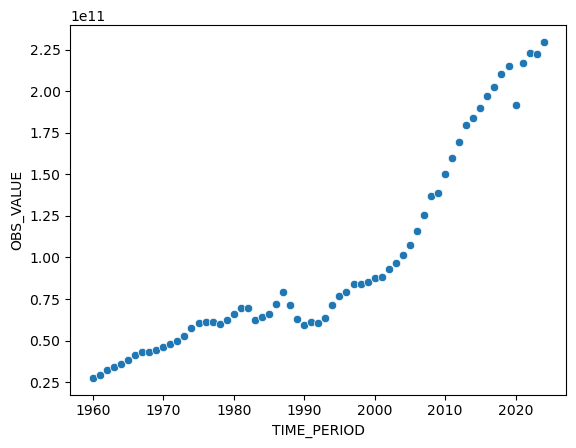

In [ ]:
sns.scatterplot(x=x,y=y,data = df_limpio)

Observamos PBI con curva y como que quiere formarse una S

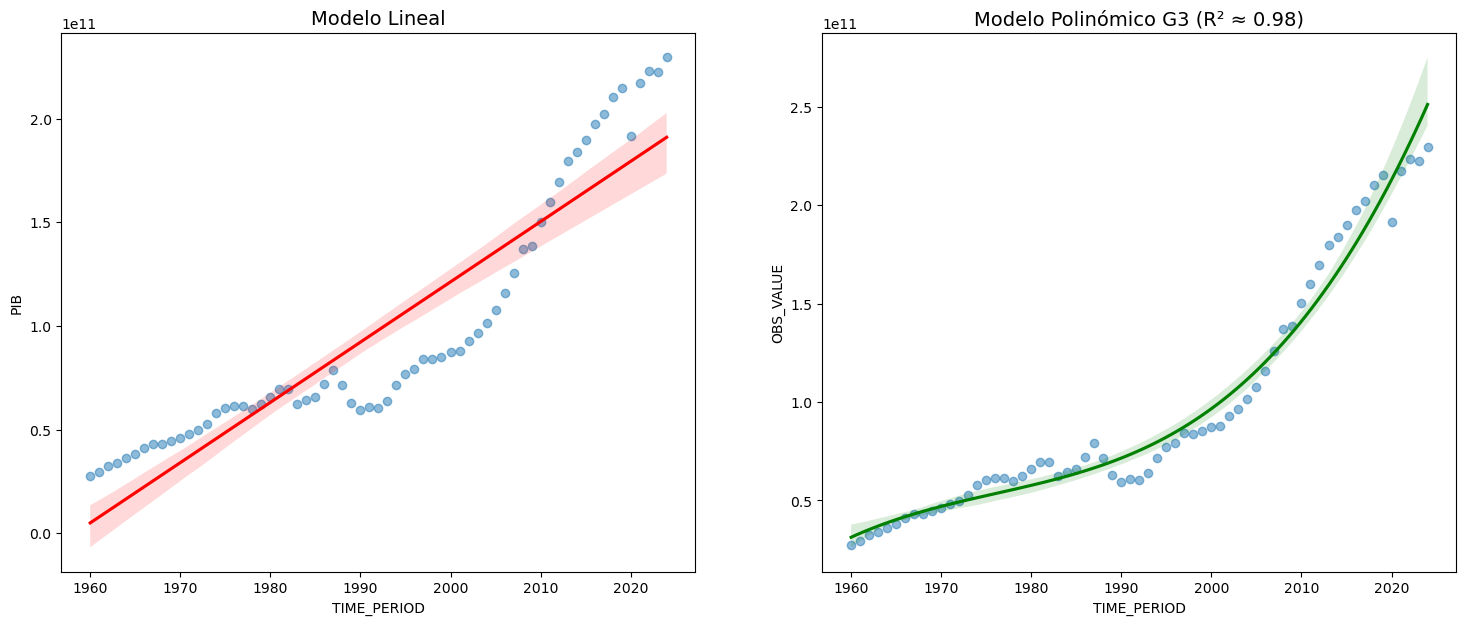

In [10]:
# grafico lineal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
sns.regplot(x='TIME_PERIOD', y='OBS_VALUE', data=df_limpio,
                    ax=ax1,
                    order=1,
                    line_kws={'color': 'red'},
                    scatter_kws={'alpha': 0.5})
ax1.set_title('Modelo Lineal', fontsize=14)
ax1.set_ylabel('PIB')

#linea de regresion de grado 3
sns.regplot(x='TIME_PERIOD', y='OBS_VALUE', data=df_limpio,
                    ax=ax2,
                    order=3,
                    line_kws={'color': 'green'},
                    scatter_kws={'alpha': 0.5})

ax2.set_title('Modelo Polinómico G3 (R² ≈ 0.98)', fontsize=14)
plt.show()

Con este gráfico, podemos concluir que es mejor modelar estos datos con una regresión polinomial, hacemos una comparación visualmente con la regresión lineal simple, y vemos que si bien sí se ajusta, el modelo polinomial de grado 3 se ajusta mucho mejor, analizaremos ello. 

## R2 (Coeficiente de determinación)

Sabemos que el R2, es una medida de bondad de ajuste, y nos dice que tanto el modelo se ajusta a los datos o que tanto puede explicar a la variable dependiente en este caso el PBI

In [11]:
#modelo polinomial de grado 3
formula = "OBS_VALUE ~ TIME_PERIOD + I(TIME_PERIOD**2) + I(TIME_PERIOD**3)"
modelo_poli = ols(formula, df_limpio).fit()
print(modelo_poli.summary())

                            OLS Regression Results                            
Dep. Variable:              OBS_VALUE   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     734.3
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           6.81e-44
Time:                        23:17:14   Log-Likelihood:                -1600.5
No. Observations:                  65   AIC:                             3207.
Df Residuals:                      62   BIC:                             3214.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.849e+08   1

Vemos muchos valores importantes aquí, pero nos centraremos a lo que queremos ir, R2; sin embargo, es importante destacar la prueba de Jarque Bera (usado para evaluar normalidad), se cumple ese supuesto de Jarque Bera con un p.valor de 0.227; otra cosa en analizar es el R2 = 0.959 un valor alto, lo que indica que el modelo ajusta demasiado bien. 

In [12]:
#modelo lineal 

mod_lineal = ols("OBS_VALUE ~ TIME_PERIOD", data=df_limpio).fit()
print(mod_lineal.summary())

                            OLS Regression Results                            
Dep. Variable:              OBS_VALUE   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     338.0
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           5.21e-27
Time:                        23:21:13   Log-Likelihood:                -1644.6
No. Observations:                  65   AIC:                             3293.
Df Residuals:                      63   BIC:                             3298.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.693e+12   3.15e+11    -18.073      

De forma similar vemos que el R2 = 0.843, es un valor alto y bueno, pero en comparación con el otro modelo, el otro gana

In [13]:
r2_lineal = mod_lineal.rsquared
r2_poly = modelo_poli.rsquared
if r2_poly > r2_lineal:
    print(f"El modelo polinomial explica mejor al PBI con un r2 de {round(r2_poly,2)*100} %")
else:
    print(f"El modelo lineal explica mejor al PBI con un r2 de {round(r2_lineal,2)*100} %")


El modelo polinomial explica mejor al PBI con un r2 de 96.0 %


## **Supuestos**

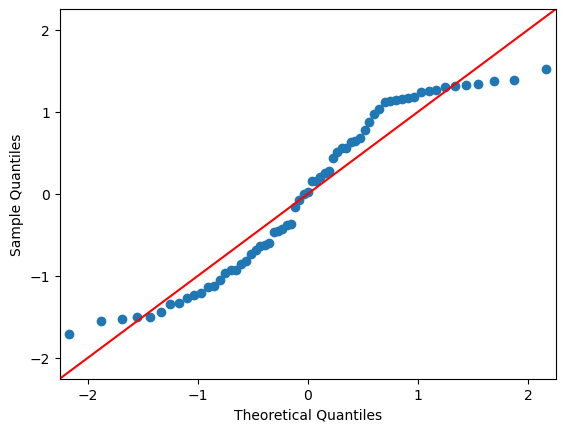

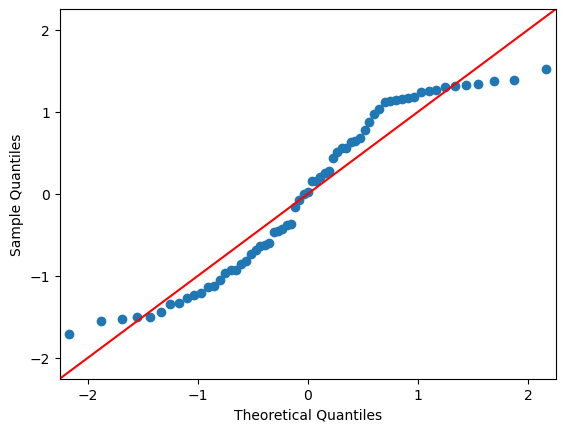

In [22]:
sm.qqplot(modelo_poli.resid, fit=True, line='45')

## **Predicciones**


In [25]:
#Definimos los años futuros que queremos proyectar
años_futuros = [2025, 2026, 2027, 2028, 2029, 2030]

In [28]:
# Creamos  la misma columna con otros datos
df_proyeccion = pd.DataFrame({'TIME_PERIOD': años_futuros})
print(df_proyeccion)

   TIME_PERIOD
0         2025
1         2026
2         2027
3         2028
4         2029
5         2030


In [31]:
predicciones = modelo_poli.predict(df_proyeccion)
predicciones

0    2.419115e+11
1    2.492236e+11
2    2.566710e+11
3    2.642540e+11
4    2.719727e+11
5    2.798273e+11
dtype: float64

In [34]:
#mostramos los resultados en la tabla
resultados = pd.DataFrame({
    'Año': años_futuros,
    'PIB_Estimado': predicciones
})
resultados

,Año,PIB_Estimado
0,2025,2.419115e+11
1,2026,2.492236e+11
2,2027,2.566710e+11
3,2028,2.642540e+11
4,2029,2.719727e+11
5,2030,2.798273e+11


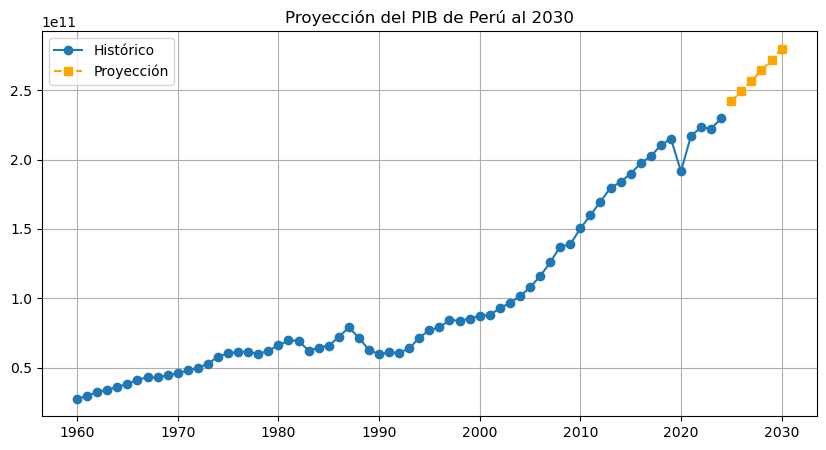

In [40]:
#visualizamos el resultado con los datos que ya teniamos 
plt.figure(figsize=(10, 5))
plt.plot(df_limpio['TIME_PERIOD'], df_limpio['OBS_VALUE'], label='Histórico', marker='o')
plt.plot(resultados['Año'], resultados['PIB_Estimado'], label='Proyección',linestyle='--', marker='s', color='orange')
plt.title('Proyección del PIB de Perú al 2030')
plt.legend()
plt.grid()
plt.show()